# Welcome to the Speech Clustering Competition

## Set up

The dataset presented is the transcripts of U.S. Congressional floor debates for different proposed legislations [1]. Instead of providing the raw dataset we have done some preprocessing and extracted the features from the raw dataset. The data set consists 2740 speeches from 38 debates. The preprocessed dataset is provided in two parts. The first part consists of a vector per speech consisting of features extracted from the text of the speech. The second part consists of a graph linking speeches. This graph is represented as an adjacency matrix of size 2740*2740. Following is a brief description of the files provided.

Dataset Description:

1) “csr_vectors.npz”
SciPy sparse matrix save file representing 2740 speeches each encoded as a 50000 dimension vector.  Bag-of-words model is used to represent each speech and the feature set has been chosen based on the debate text. Each entry of a vector is a number proportionate to the frequency (normalized frequency) of the corresponding word in that document. The matrix is in "<a href="https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)">CSR</a>" format. 

2) “speech_graph_sparse.npz”
This file contains a noisy graph of debates represented as adjacency matrix of dimension 2740*2740 a SciPy sparse matrix save file. Two speeches are connected in the graph (with some probability) if they both are in favor or against of a certain legislation. Two speeches are also connected (with some probability) if they occur in the debate for same legislation. In general, with some low probability noisy links might occur. This matrix is represented in <a href="https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)">COO</a> format.

To load the matrices into memory, you should use the following snippet:
```
import scipy.sparse as sp
vectors = sp.load_npz('../resource/asnlib/publicdata/csr_vectors.npz')
graph = sp.load_npz('../resource/asnlib/publicdata/speech_graph_sparse.npz')
```

Reference:
[1] Matt Thomas, Bo Pang, and Lillian Lee, “Get out the vote: Determining support or opposition from Congressional floor-debate transcripts”, Proceedings of EMNLP, pp. 327--335, 2006

## The challenge

Using the text and the graph information amongst the speeches, your goal is to cluster the 2740 speeches into two groups, the first group consisting of “Against” speeches and the second group consisting of “For” speeches. To start you off, you are told that points (rows, where the first row is number 0) 2, 13, 18, 24 are examples of speeches that belong to category “Against" (=label 0) and speeches 1, 3, 27, 177 are examples of speeches that belong to the “For”(=label 1) category. Your goal is to produce a 2740 x 2 numpy array named `prediction`, where:

The first column indicates which speech is being referred to, starting with speech 0, and the second column is either "0” or “1”. So, the first row of the array in the array will be either "0,0" or "0,1". You will save this array to the file `result.npy` using the code in the Jupyter notebook cells below. 

We will evaluate your grouping against the ground truth (which is of course hidden from you — but from the information above, you know that some of its lines are "1,1", "2,0", "3,1", "177,1", etc. ). Your goal is to make as few mistakes as possible. We will evaluate how well your clustering predicts the actual categories of the articles and return to you accuracy in percentage. Higher the better.

You can use any library you need and write your own method. You can work in groups of size at most 4. 

## Tips:
**Be careful with these large matrices!** For instance, eigendecomposing a very large matrix can be expensive in terms of time and memory! If you only need some eigenvalues, try only computing those eigenvalues. 

If you find Vocareum is being slow, you can download the datasets and develop your solution on your own computer. 

In [220]:
#<GRADED>
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix, coo_matrix
from zipfile import ZipFile
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.random_projection import SparseRandomProjection
from sklearn.manifold import SpectralEmbedding
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_decomposition import CCA
import seaborn as sns
#</GRADED>

In [268]:
#<GRADED>
def Competition_solution():

# Store matrix in sparse matrix format and write to file
    # X =  csr_matrix(X)
    # sp.sparse.save_npz('data_your_name.npz', XX)

# We load the extracted features into X and the graph into variable G

# Now we load the graph and the data matrix (saved as a sparse matrix)
    X = sp.load_npz('../resource/asnlib/publicdata/csr_vectors.npz')
    G = sp.load_npz('../resource/asnlib/publicdata/speech_graph_sparse.npz')

    n = X.shape[0]


# Fill in your code below to do whatever you want so it fills in predictions for the 
# speeches to be one of the two classes {0,1}. Currently I have set it to 
# randomly pick labels for the speeches.

    
 
    # BEGIN: Get the TF-IDF matrix
    # Step 1: Get sums of words vector
    B = np.diff(X.tocsc().indptr)
    # Step 2: Calculate the IDF score
    IDF = sp.diags([np.log(n/B)], [0])
    # Step 3: apply the IDF score to the TF score (X) by element-wise multiplication across the rows
    TFIDF = X.copy().dot(IDF)
    # END: Get the TF-IDF matrix

    
    # BEGIN: Drop low-variance terms that have little value
#     print("Init: ", X.shape)
    selector = VarianceThreshold()
    TFIDF_clean = selector.fit_transform(TFIDF).toarray()[:,:100]
#     print("Init: ", TFIDF_clean.shape)
    # END: Drop low-variance

    # BEGIN: Dimensionality-reduction on TFIDF
    pca = PCA(n_components=3)
    TFIDF_pca = pca.fit_transform(TFIDF_clean)
    # END: Dimensionality-reduction on TFIDF
    
    # BEGIN: Spectral embedding (get affinity matrix)
#     tsne = TSNE(n_components=2)
#     TFIDF_low = tsne.fit_transform(TFIDF_pca)
    embedding = SpectralEmbedding(n_components=20, affinity='precomputed').fit_transform(G.toarray())
    cca = CCA(n_components=3)
    cca.fit(TFIDF_pca, embedding[:,[3, 4, 7]])
    U, V = cca.transform(TFIDF_pca, embedding[:,[3, 4, 7]]) # 7
    clusters = KMeans(n_clusters=2, max_iter=20000).fit(V)
    # END: Spectral embedding

    prediction = np.hstack([np.arange(n).reshape(-1, 1), clusters.labels_.reshape(-1, 1)])

    return prediction, U, V, TFIDF_clean, embedding
#     return prediction

#</GRADED>

In [269]:
# prediction = Competition_solution()
prediction, U, V, T, E = Competition_solution()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


In [273]:
E[:,[3,4]]

array([[-3.79863482e-04, -9.98498173e-04],
       [-9.60961052e-04, -4.15398297e-04],
       [ 4.60833656e-04, -8.42651690e-04],
       ...,
       [-5.34806951e-04, -9.61304127e-05],
       [-6.11820724e-04, -2.46324859e-04],
       [-6.37356066e-04, -9.64510825e-04]])

In [275]:
V[:,[0,1]]

array([[-0.78362592, -2.30036873],
       [-0.16317577, -1.03369709],
       [-1.14687627,  0.05063188],
       ...,
       [ 0.16555089, -0.9743896 ],
       [-0.03893139, -0.84041385],
       [-1.49421602,  2.13615045]])

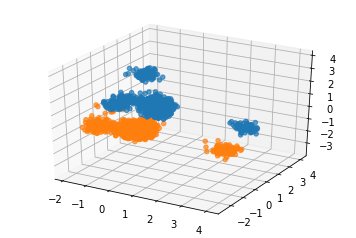

In [270]:
j = 7
customPalette = sns.color_palette()
x = V[:,0]
y = V[:,1]
z = V[:,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0,2):

    #add data points 
    ax.scatter(xs=x[prediction[:,1]==i], 
                ys=y[prediction[:,1]==i], 
                zs=z[prediction[:,1]==i], 
                color=customPalette[i], 
                alpha=0.7)

In [271]:
print("Ratio of zero to nonzero, should be ~52.2%: ", max(1 - (np.count_nonzero(prediction[:,1])/len(prediction)), np.count_nonzero(prediction[:,1])/len(prediction)))
print("Predicted values for known transcripts. First half should be different than second half: ", prediction[[2, 13, 18, 24, 1, 3, 27, 177]][:,1])

Ratio of zero to nonzero, should be ~52.2%:  0.5142335766423358
Predicted values for known transcripts. First half should be different than second half:  [0 0 0 0 1 1 1 0]


The following code will generate a `result.npy` file, which contains your final prediction that we will grade upon. If you want to work offline instead, you can save your work as below with the title of `result.npy` and utilize the upload feature on Vocareum for grading. 

In [235]:
np.save('result.npy', prediction)